In [1]:
# !pip install graphviz
# !pip install torch
# !pip install tensorflow
# !pip install matplotlib

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot


In [3]:
from __future__ import annotations
import math
import random

class Value:
    def __init__(self, value, children=(), op = ""):
        self.data = value
        self.children = set(children)
        self.label = ""
        self.op = op
        self.grad = 0.0
        self.backward = lambda: None

    def __str__(self) -> str:
        return f"Value({self.data})"

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        output = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output.backward = _backward
        return output

    def __radd__(self, other) -> Value:
        return self.__add__(other)

    def __mul__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        output = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += output.grad * other.data
            other.grad += output.grad * self.data

        output.backward = _backward
        return output
    
    def __rmul__(self, other) -> Value:
        return self.__mul__(other)

    def __pow__(self, other):
        other = other if isinstance(other, (int, float)) else other.data

        output = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
    
        output.backward = _backward
        return output
    
    def __rpow__(self, other) -> Value:
        return self.__pow__(other)

    def __truediv__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        return self * (other ** -1)

    def __rtruediv__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        return other * (self ** -1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other) -> Value:
        return self.__sub__(other)

    def exp(self):
        data = self.data
        output = Value(math.exp(data), (self, ), 'exp')
        
        def _backward():
            self.grad += output.data * output.grad
            
        output.backward = _backward
        return output

    def set_label(self, label):
        self.label = label

    def set_grad(self, grad):
        self.grad = grad

    def backprop(self, initial = True):
        # if initial: self.set_grad(1.0)
        # self.backward()
        # for child in self.children:
        #     child.backprop(False)

        topo = []
        visited = set()
    
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
    
        build_topo(self)
        self.set_grad(1.0)
        for node in reversed(topo):
            node.backward()



In [5]:
import enum

class ActivationFunction(enum.Enum):
    TANH = "tanh"
    RELU = "relu"
    SIGMOID = "sigmoid"

def tanh(x: Value) -> Value:
    e = (2*x).exp()
    output = (e - 1) / (e + 1)

    return output

def relu(x: Value) -> Value:
    data = x.data
    output = Value(max(0, data), (x, ), 'relu')
    
    def _backward():
        x.grad += int(data > 0)
        
    output.backward = _backward
    return output

def sigmoid(x: Value) -> Value:
    output = 1 / (1 + (-x).exp())

    return output

def softmax(x: Value) -> Value:
    pass


activation_functions = {
    ActivationFunction.TANH: tanh,
    ActivationFunction.RELU: relu,
    ActivationFunction.SIGMOID: sigmoid,
}


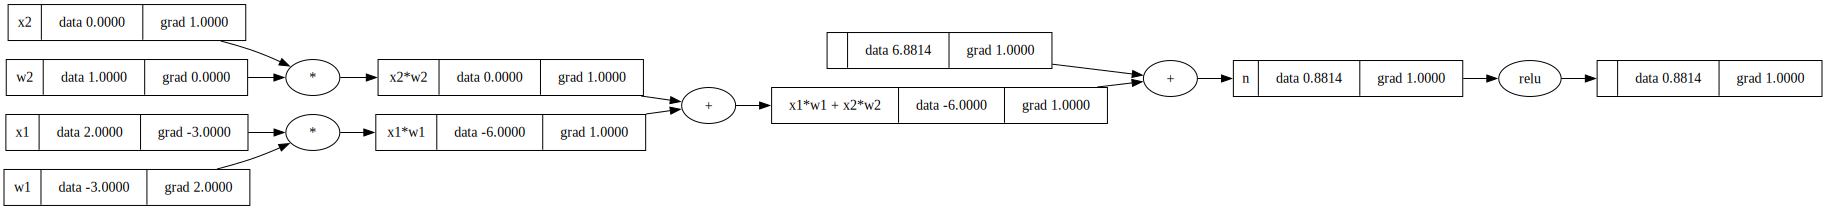

In [25]:
# inputs x1,x2
x1 = Value(2.0); x1.set_label("x1")
x2 = Value(0.0);x2.set_label("x2")
# weights w1,w2
w1 = Value(-3.0);w1.set_label("w1")
w2 = Value(1.0);w2.set_label("w2")
# bias of the neuron
b = Value(6.8813735870195432)
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = relu(n)

o.backprop()
draw_dot(o)

In [29]:

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.act_func = act_func=ActivationFunction.TANH

    def __call__(self, x):
        # w * x + b
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        output = activation_functions[self.act_func](act)
        return output
      
    def parameters(self):
        return self.w + [self.b]

    def change_act_func(act_func):
        self.act_func = act_func

class Layer:
    def __init__(self, nin, nout, act_func=ActivationFunction.RELU):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.act_func = act_func
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def change_act_func(act_func):
        for neuron in self.neurons:
            neuron.change_act_func(self.act_func)


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
a = m(x)
a.backprop()
a
        

Value(0.6435254310300973)

In [30]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [33]:
for k in range(20):
  
    ypred = [m(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in m.parameters():
        p.set_grad(0.0)
    
    loss.backprop()
    
    for p in m.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data, ypred)
  

0 0.0063626534986450526 [Value(0.9723857217132426), Value(-0.9545159657912818), Value(-0.9543054348096176), Value(0.9620090211035749)]
1 0.006218291660212808 [Value(0.9727061448135422), Value(-0.9550348269718772), Value(-0.9548330668442081), Value(0.962431149962706)]
2 0.006080252279488244 [Value(0.9730156677560962), Value(-0.9555369137077939), Value(-0.9553435294330329), Value(0.9628391107922282)]
3 0.0059481301489742264 [Value(0.9733148971884625), Value(-0.9560231046154657), Value(-0.955837726711856), Value(0.9632336876030121)]
4 0.0058215539445358256 [Value(0.973604393391124), Value(-0.956494215347512), Value(-0.956316497714786), Value(0.9636156046339323)]
5 0.005700182754806099 [Value(0.9738846747461737), Value(-0.9569510042735568), Value(-0.9567806222737562), Value(0.9639855321073059)]
6 0.005583703028980548 [Value(0.9741562216897388), Value(-0.9573941775469678), Value(-0.9572308262776579), Value(0.9643440913193979)]
7 0.00547182588525025 [Value(0.9744194802172866), Value(-0.95782

In [2]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [1]:
import tensorflow as tf

x1 = tf.Variable([2.0], dtype=tf.float64)
x2 = tf.Variable([0.0], dtype=tf.float64)
w1 = tf.Variable([-3.0], dtype=tf.float64)
w2 = tf.Variable([1.0], dtype=tf.float64)
b = tf.Variable([6.8813735870195432], dtype=tf.float64)

n = x1 * w1 + x2 * w2 + b

print(n.numpy().item())

with tf.GradientTape() as tape:
    n = x1 * w1 + x2 * w2 + b

grads = tape.gradient(n, [x1, x2, w1, w2, b])

print('---')
print('x2', grads[1].numpy().item())
print('w2', grads[3].numpy().item())
print('x1', grads[0].numpy().item())
print('w1', grads[2].numpy().item())


2024-09-12 18:17:15.750703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 18:17:15.859656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 18:17:15.888870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 18:17:16.094665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 18:17:17.230962: W tensorflow/compiler/tf2

0.8813735870195432
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class XORNetwork(nn.Module):
    def __init__(self):
        super(XORNetwork, self).__init__()
        self.hidden = nn.Linear(in_features=2, out_features=2)  # Hidden layer
        self.output = nn.Linear(in_features=2, out_features=1)  # Output layer

    def forward(self, x):
        x = F.relu(self.hidden(x)) 
        x = torch.sigmoid(self.output(x))
        return x

model = XORNetwork()


In [11]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# XOR input and output data
inputs = torch.tensor([[0.0, 0.0],
                       [0.0, 1.0],
                       [1.0, 0.0],
                       [1.0, 1.0]], dtype=torch.float32)
targets = torch.tensor([[0.0], [1.0], [1.0], [0.0]], dtype=torch.float32)


# Number of epochs
epochs = 10000

for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, targets)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.7440416216850281
Epoch 1000, Loss: 0.025409312918782234
Epoch 2000, Loss: 0.010081389918923378
Epoch 3000, Loss: 0.006137249059975147
Epoch 4000, Loss: 0.004370155744254589
Epoch 5000, Loss: 0.003379428992047906
Epoch 6000, Loss: 0.0027468805201351643
Epoch 7000, Loss: 0.0023107770830392838
Epoch 8000, Loss: 0.0019910151604562998
Epoch 9000, Loss: 0.0017478432273492217
